In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import hashlib

In [3]:
r_0 = None
def get_r_0(pref1='FISI',pref2='2028'):
    '''
        Funcion para determinar r_0 usando un algoritmo de hash
    '''
    global r_0
    def get_codigo():
        while True:
            try:
                c = int(input("Ingrese su código de estudiante "))       
            except ValueError:
                print("El código debe ser un entero")
                continue
            else:
                if c < 300000000 and c > 190000000:
                    return c
                else:
                    print("El código no parece ser válido. Intente nuevamente")
    def hasher(key, n):
        # sum ASCII values and convert string to integer
        lst = [ord(char) for char in list(key)]
        return np.sum(lst) % n
    codigo = get_codigo()
    key1 = hashlib.sha256((pref1+str(codigo)).encode('utf-8'))
    key2 = hashlib.sha256((pref2+str(codigo)).encode('utf-8'))
    r_0 = np.array([
        hasher(key1.hexdigest(),100)/10+26,
        hasher(key2.hexdigest(),400)/10-20,
        0
    ])
    print("Posición inicial r_0=(x=%.1fm,y=%.1fm,z=%.1fm)"%(r_0[0],r_0[1],r_0[2]))
get_r_0()

Ingrese su código de estudiante  201513349


Posición inicial r_0=(x=34.7m,y=-7.7m,z=0.0m)


In [4]:
# Reducción dimensional
r_0=np.array([29.4,8.9])

r=np.array([105/2,7.35/2]) # asumiendo que el gol se haga en la esquina del arco de Khan
shot=norm(r_0-r) #normalizndo
shot

23.683551781774625

In [5]:
# Ec. mov.
m = 0.450 
radio = 0.11 
g = 9.8 
rho = 1.2 #del aire
cancha = 2.44 #alto
v_max = 183.0
A = np.pi*radio**2

def arrastre(v):
    # velocidad en 'x', 'y' y 'z'
    return 0.155+0.346/(1+np.exp((norm(v)-12.19)/1.309))
    # Tomado de : https://www.researchgate.net/publication/228375759_Soccer_ball_lift_coefficients_via_trajectory_analysis
def kappa(v):
    return rho*A*norm(v)*arrastre(v)/(2*m)
def dv_dt(v):
    return -kappa(v)*v-np.array([0,g])

In [6]:
#Rungekutta
def RK_4(F,x,dt=1e-2):
    a = F(x)
    b = F(x+dt/2*a)
    c = F(x+dt/2*b)
    d = F(x+dt*c)
    return x+dt/6*(a+2*b+2*c+d)

In [7]:
def simulacion(F,v_0,dt=5e-3):
    x_vec = np.zeros(2)
    v_vec = v_0
    t = 0.0
    while x_vec[0]<shot:
        v_vec = RK_4(F,v_vec,dt)
        x_vec += v_vec*dt
        if (abs(x_vec[0]-9.15)<2*radio and x_vec[1]<1.8+2*radio): #si toca barrera
            return np.zeros(2),0.0
        if norm(v_vec)>v_max:
            return np.zeros(2),0.0
        t+=dt
    return x_vec,t #posicion final, tiempo

In [8]:
simulacion(dv_dt,np.array([20,20]))

(array([23.72564284, 15.52273373]), 1.3399999999999934)

In [9]:
def f_costo(h_fin):
    return np.exp(-(h_fin-cancha/2)**2/5)
def s_costo(v_0,dt=5e-3):
    (x_fin,h_fin),t_fin = simulacion(dv_dt,v_0,dt)
    if t_fin == 0.0:
        return 0.0 
    else:
        return f_costo(h_fin)

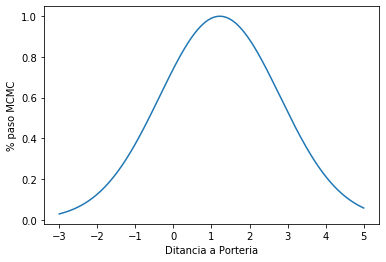

In [10]:
xp=np.linspace(-3,5,300)
yp = [f_costo(i) for i in xp]
plt.plot(xp,yp)
plt.xlabel("Ditancia a Porteria")
plt.ylabel("% paso MCMC");

In [11]:
def MH(v,costo,mult=1):
    P = costo(v)
    v_new = v+mult*np.random.normal(size=len(v))
    p_new = costo(v_new)
    aleatorio = np.random.random()
    if aleatorio < p_new/P:
        return v_new
    else:
        return v

In [12]:
v_real = np.array([10,10])

ev_costo=[s_costo(v_real)]

while abs(ev_costo[-1]-1)>0.1:
    v_real = MH(v_real,s_costo,mult=.5)
    print("{:10.5}".format(s_costo(v_real)),end="\r")
    ev_costo.append(s_costo(v_real))


0.9053766410053471

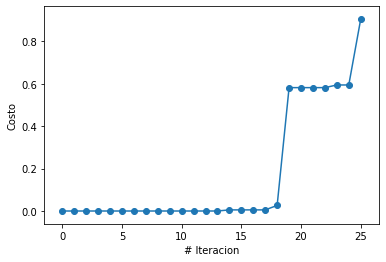

In [13]:
plt.plot(range(len(ev_costo)),np.array(ev_costo))
plt.scatter(range(len(ev_costo)),np.array(ev_costo))
plt.xlabel("# Iteracion")
plt.ylabel("Costo")
ev_costo[-1]

In [14]:
v_real

array([14.00055404, 11.41096366])

In [15]:
(xmax,h_end),tmax=simulacion(dv_dt,v_real)
h_end #golazo y pa la casa, si da menor a 2.44

1.9249973189798475

In [16]:
v_x,v_y = v_real[0]*(r-r_0)/shot
v_z = v_real[1]

In [17]:
print("velocidad en x, y, z =  ",[v_x,v_y,v_z])

velocidad en x, y, z =   [13.655586853388705, -3.088763693028398, 11.410963662448763]


In [18]:

def RK4(F,x0,stop=lambda x,t:t<=1,dt=1e-3):
    x_array = [x0]
    t_array = [0.0]
    while stop(x_array[-1],t_array[-1]):
        x_array.append(RK_4(F,x_array[-1],dt))
        t_array.append(t_array[-1]+dt)
    return (np.array(x_array),np.array(t_array))
        

def trapezoide(x_array,y_array):
    return np.sum((y_array[:-1]+y_array[1:])*(np.diff(x_array))/2)

Text(0, 0.5, 'Velocidad (m/s)')

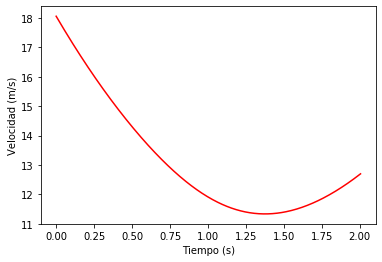

In [23]:
v_ini=v_real
vsol,tsol=RK4(dv_dt,v_ini,stop=lambda x,t:t<tmax,dt=5e-3)
vxsol,vhsol=np.array(vsol).T


plt.plot(tsol,[norm([i,j]) for i,j in zip(vxsol,vhsol)],c='r')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (m/s)")

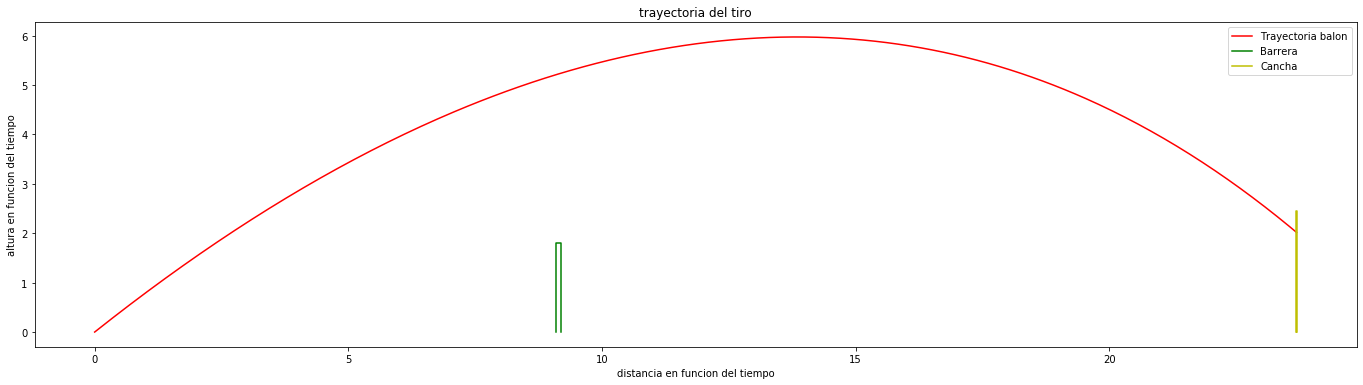

In [22]:
xsol=[trapezoide(tsol[:i],vxsol[:i]) for i in range(0,len(tsol))]
hsol=[trapezoide(tsol[:i],vhsol[:i]) for i in range(0,len(tsol))]

plt.figure(figsize=(max(xsol),max(hsol)))
plt.plot(xsol,hsol,c='r',label="Trayectoria balon")
plt.title('trayectoria del tiro')
plt.xlabel("distancia en funcion del tiempo")
plt.ylabel("altura en funcion del tiempo")
plt.plot([9.1,9.1,9.2,9.2],[0,1.8,1.8,0],c='g',label="Barrera")
plt.plot([shot-0.01,shot-0.01,shot+0.01,shot+0.01],[0,cancha,cancha,0],c='y',label="Cancha")
plt.legend()

In [25]:

def trapezoide(x_array,y_array):
    return np.sum((y_array[:-1]+y_array[1:])*(np.diff(x_array))/2)

def simpson(x_array,y_array):
    s=0.0
    for i in range(0,len(x_array),2):
        if i+2<len(x_array): 
            s+=((x_array[i]-x_array[2+i])*\
                ((2*x_array[i]-3*x_array[1+i]+x_array[2+i])*\
                 (-x_array[1+i]+x_array[2+i])*\
                 y_array[i]-(x_array[i]-x_array[2+i])**2*\
                 y_array[1+i]+(x_array[i]-x_array[1+i])*\
                 (x_array[i]-3*x_array[1+i]+2*x_array[2+i])*y_array[2+i]))/\
            (6*(x_array[i]-x_array[1+i])*(x_array[1+i]-x_array[2+i]))
    

    if i < len(x_array):
        sobra = len(x_array)-i
        s+=trapezoide(x[-sobra:],y[-sobra:])
    return s

In [26]:
x = np.linspace(0,np.pi/2,3000)
y = np.cos(x)
simpson(x,y) 

0.9999999999999997

2.00000320286046

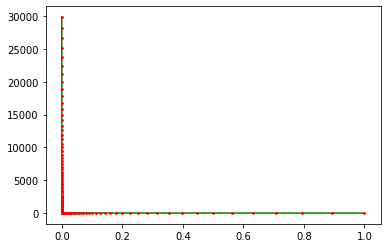

In [30]:
#MAlla
x = 10**(-np.flip(np.arange(0,9,0.05)))
y = 1/np.sqrt(x)

plt.plot(x,y,c = 'g')
plt.scatter(x,y,s=3,c='r',zorder=100)

simpson(x,y) 